In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from skimage.morphology import convex_hull_image
import skimage

In [2]:
from matplotlib.colors import ListedColormap

colors={0: 'darkgray', 1: '#FDBF6F', 2: '#A065BD'}
cmap = ListedColormap(colors.values())

In [3]:
plt.rcParams['figure.figsize'] = (10,10)
plt.rc('axes', linewidth=2)

In [4]:
# cell label for each transcript
df = pd.read_csv('../topact-data/kidney-stereoseq/cellbin/4032_2_cellbin.txt', sep='\t')

# restrict to 4032_2 sample
df = df[df.x < 10000]

# remove transcripts without assigned cell
df = df[df.label != 0]

# translate coordinates
df['newx'] = df.x - 4880
df['newy'] = df.y - 10762

In [5]:
df

,geneID,x,y,UMICount,label,newx,newy
0,Cr2,5747,10991,1,3703,867,229
1,Ube2w,5747,10991,1,3703,867,229
11,Cr2,5578,11575,3,10016,698,813
12,Atp5d,5578,11575,1,10016,698,813
13,Smim7,5578,11575,1,10016,698,813
...,...,...,...,...,...,...,...
4136658,CAAA01118383.1,5659,11393,4,7968,779,631
4136659,CAAA01118383.1,5304,12532,2,18886,424,1770
4136660,CAAA01118383.1,6690,12510,1,18793,1810,1748
4136661,CAAA01118383.1,6073,10844,1,2457,1193,82


In [6]:
# topact predicted immune and pod coords
immunes = np.loadtxt('../topact-data/kidney-stereoseq/immune-coords/4032_2_immunes.txt')

pods = np.loadtxt('../topact-data/kidney-stereoseq/pod-coords/4032_2_pods.txt')

In [7]:
# return all transcript coords with the given label
def get_points(df, label):
    dflabel = df[df.label == label]
    
    return np.array(list(zip(list(dflabel.newy), list(dflabel.newx))))

In [20]:
compute_from_scratch = False

if compute_from_scratch:
    cellbin_arr = np.zeros((2198, 2120))
    workingarr = np.zeros_like(cellbin_arr)

    # all cell ids in cellbin
    labels = list(set(list(df.label)))

    # this will take a while
    # for each cellbin cell, computes convex hull of transcripts and adds to cellbin_arr
    for label in labels:

        workingarr[:] = 0

        cell = df[df.label == label]

        points = set(list(zip(cell.newx, cell.newy)))

        for x,y in points:
            if x > 0 and y > 0:
                try:
                    workingarr[y,x] = 1
                except IndexError:
                    pass

        chull = convex_hull_image(workingarr)

        cellbin_arr[np.where(chull != 0)] = label
        
else:
    cellbin_arr = np.loadtxt('../topact-data/kidney-stereoseq/cellbin/cellbin_arr.txt')

In [10]:
def all_hitting(target, darts, threshold=20):
    x0, y0 = target
    hits = []
    for i, dart in enumerate(darts):
        x,y = dart
        if (d2 := (x-x0)**2 + (y-y0)**2) <= threshold**2:
            hits.append((i, d2))
    return hits

rp = skimage.measure.regionprops(cellbin_arr.astype('int'))

ssdnacoords = [props.centroid for props in rp]

In [11]:
# assigns cellbins to each topact-predicted cell

immunelabels = {}
for i, immune in enumerate(immunes):
    x,y = immune
    if (l := cellbin_arr[int(x), int(y)]) != 0:
        immunelabels[i] = l
        
podlabels = {}
for i, immune in enumerate(pods):
    x,y = immune
    if (l := cellbin_arr[int(x), int(y)]) != 0:
        podlabels[i] = l
        

for i, immune in enumerate(immunes):
    x,y = immune
    if i not in immunelabels:
        hits = all_hitting(immune, ssdnacoords, threshold=10)
        if len(hits) > 0:
            hits = sorted(hits, key= lambda u: u[1],)
            first = hits[0]
            hits = list(filter(lambda x: rp[x[0]].label not in immunelabels.values() and rp[x[0]].label not in podlabels.values(), hits))
            if len(hits) > 0:
                # choose the closest
                immunelabels[i] = rp[hits[0][0]].label
            else:
                # we have a clash
                immunelabels[i] = rp[first[0]].label
            

for i, immune in enumerate(pods):
    x,y = immune
    if i not in podlabels:
        hits = all_hitting(immune, ssdnacoords, threshold=10)
        if len(hits) > 0:
            hits = sorted(hits, key= lambda u: u[1])
            first = hits[0]
            hits = list(filter(lambda x: rp[x[0]].label not in immunelabels.values() and rp[x[0]].label not in podlabels.values(), hits))
            if len(hits) > 0:
                # choose the closest
                podlabels[i] = rp[hits[0][0]].label
            else:
                # we have a clash
                podlabels[i] = rp[first[0]].label

In [12]:
newarr = np.zeros_like(cellbin_arr)

for label in immunelabels.values():
    
    if label != 0:
        newarr[np.where(cellbin_arr == label)] = 1
        
for label in podlabels.values():
    
    if label != 0:
        newarr[np.where(cellbin_arr == label)] = 2
        
        
newarr[np.where(newarr == 0)] = np.nan
newarr[np.where((cellbin_arr != 0) & (np.isnan(newarr)))] = 0

In [13]:
celllabels = [1] * len(immunes) + [2] * len(pods)

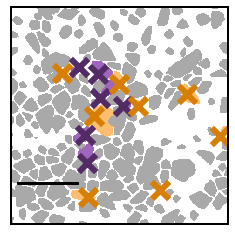

In [14]:
plt.imshow(newarr.T, origin='lower', interpolation='None', cmap=cmap)

plt.scatter(pods[:,0], pods[:,1], marker='x', facecolor='#532C66', s=300, linewidth=6)
plt.scatter(immunes[:,0], immunes[:,1], marker='x', facecolor='#D77F05', s=300, linewidth=6)

plt.xticks([])
plt.yticks([])


plt.xlim([250, 500])
plt.ylim([1350, 1600])

ax = plt.gca()
scalebar = AnchoredSizeBar(ax.transData,
                           69.93, '', 'lower left',
                           pad=0.1,
                           color='black',
                           size_vertical=3,
                           frameon=False,
                           sep=5,
                           fontproperties=fm.FontProperties(size=30))


ax.add_artist(scalebar)

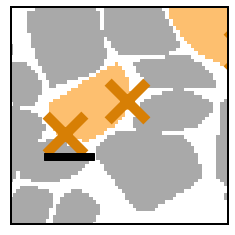

In [15]:
plt.imshow(newarr.T, origin='lower', interpolation='None', cmap=cmap)

plt.scatter(pods[:,0], pods[:,1], marker='x', facecolor='#532C66', s=1500, linewidth=10)
plt.scatter(immunes[:,0], immunes[:,1], marker='x', facecolor='#D77F05', s=1500, linewidth=10)

plt.xticks([])
plt.yticks([])

plt.xlim([590, 650])
plt.ylim([680, 740])

ax = plt.gca()
scalebar = AnchoredSizeBar(ax.transData,
                           13.98, '', 'lower left',
                           pad=1,
                           color='black',
                           size_vertical=2,
                           frameon=False,
                           sep=2,
                           fontproperties=fm.FontProperties(size=30))


ax.add_artist(scalebar)

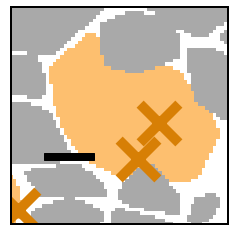

In [16]:
plt.imshow(newarr.T, origin='lower', interpolation='None', cmap=cmap)

plt.scatter(pods[:,0], pods[:,1], marker='x', facecolor='#532C66', s=1500, linewidth=10)
plt.scatter(immunes[:,0], immunes[:,1], marker='x', facecolor='#D77F05', s=1500, linewidth=10)

plt.xticks([])
plt.yticks([])

plt.ylim([710, 770])
plt.xlim([620, 680])

ax = plt.gca()
scalebar = AnchoredSizeBar(ax.transData,
                           13.98, '', 'lower left',
                           pad=1,
                           color='black',
                           size_vertical=2,
                           frameon=False,
                           sep=2,
                           fontproperties=fm.FontProperties(size=30))


ax.add_artist(scalebar)

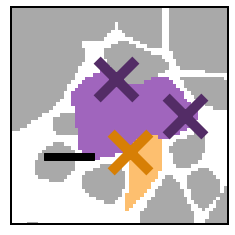

In [17]:
plt.imshow(newarr.T, origin='lower', interpolation='None', cmap=cmap)

plt.scatter(pods[:,0], pods[:,1], marker='x', facecolor='#532C66', s=1500, linewidth=10)
plt.scatter(immunes[:,0], immunes[:,1], marker='x', facecolor='#D77F05', s=1500, linewidth=10)

plt.xticks([])
plt.yticks([])

plt.xlim([510, 570])
plt.ylim([1870, 1930])

ax = plt.gca()
scalebar = AnchoredSizeBar(ax.transData,
                           13.98, '', 'lower left',
                           pad=1,
                           color='black',
                           size_vertical=2,
                           frameon=False,
                           sep=2,
                           fontproperties=fm.FontProperties(size=30))


ax.add_artist(scalebar)

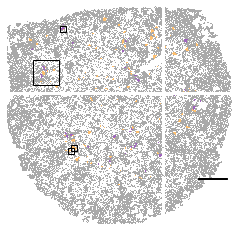

In [18]:
plt.imshow(newarr.T, origin='lower', interpolation='None', cmap=cmap)

plt.xticks([])
plt.yticks([])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

from matplotlib.patches import Rectangle

rect = Rectangle((250, 1350), 250, 250, facecolor='None', edgecolor='black')

ax.add_patch(rect)

rect = Rectangle((590, 680), 60, 60, facecolor='None', edgecolor='black')
ax.add_patch(rect)

rect = Rectangle((510, 1870), 60, 60, facecolor='None', edgecolor='black')
ax.add_patch(rect)

rect = Rectangle((620, 710), 60, 60, facecolor='None', edgecolor='black')
ax.add_patch(rect)

scalebar = AnchoredSizeBar(ax.transData,
                           279.7, '', 'lower right',
                           pad=0.1,
                           color='black',
                           size_vertical=10,
                           frameon=False,
                           sep=10,
                           fontproperties=fm.FontProperties(size=30))


ax.add_artist(scalebar)